In [309]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from pylab import imread, imshow, imsave, plt
from enum import Enum
import matplotlib
import os

class Dataset(Enum):
    """Three different datasets."""
    DRIVE = 0
    STARE = 1
    CHASE = 2

DRIVE_TRAINING_IMAGES_PATH = '../../data/DRIVE/training/images/'
DRIVE_TRAINING_SEG_1_PATH = '../../data/DRIVE/training/1st_manual/'
DRIVE_TRAINING_MASK_PATH = '../../data/DRIVE/training/mask/'
DRIVE_TEST_IMAGES_PATH = '../../data/DRIVE/test/images/'
DRIVE_TEST_SEG_1_PATH = '../../data/DRIVE/test/1st_manual/'
DRIVE_TEST_SEG_2_PATH = '../../data/DRIVE/test/2nd_manual/'
DRIVE_TEST_MASK_PATH = '../../data/DRIVE/test/mask/'

CHASE_IMAGES_PATH = '../../data/CHASEDB1/images/'
CHASE_SEG_1_PATH = '../../data/CHASEDB1/segmentation/1st/'
CHASE_SEG_2_PATH = '../../data/CHASEDB1/segmentation/2nd/'
CHASE_MASK_PATH = '../../data/CHASEDB1/masks/'

STARE_IMAGES_PATH = '../../data/STARE/img/'

In [286]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image = imread(folder_path + filename)
            images.append(image)
        except:
            continue
            
    return images
    

In [301]:
def get_patches_with_mask(image, labels, m, n_patches, mask, condition_function):
    patches = []
    label_patches = []
    while len(patches) < n_patches:
        random_x, random_y = (random.randint(int(m/2),image.shape[0] - int(m/2)) - 1, random.randint(int(m/2), image.shape[1] - int(m/2)) - 1)
        start_x = random_x - int(m/2)
        end_x = random_x + int(m/2)
        start_y = random_y - int(m/2)
        end_y = random_y + int(m/2)
        mask_patch = mask[start_x : end_x,start_y:end_y]
        #fig = plt.figure()
        # check if mask contains 0 values
        if condition_function(mask_patch):
            #print('invalid')
            continue
        else:
            #print('valid')
            image_patch = image[start_x : end_x,start_y:end_y]
            label_patch = labels[start_x : end_x,start_y:end_y]
            patches.append(image_patch)
            label_patches.append(label_patch)
        '''
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(image_patch)
        ax2 = fig.add_subplot(2,2,2)s
        ax2.imshow(mask_patch)
        ax3 = fig.add_subplot(2,2,3)
        ax3.imshow(label_patch)'''
    return patches, label_patches

In [302]:
def get_image_pathes(image, labels, m, n_patches, dataset, mask=None):
    """"""
    if dataset == Dataset.DRIVE:
        if mask is None:
            raise Exception('Mask must be provided for DRIVE dataset')
        def mask_condition(mask_patch):
            return any(0 in row for row in mask_patch)
        return get_patches_with_mask(image, labels, m, n_patches, mask, mask_condition)
    elif dataset == Dataset.CHASE:
        if mask is None:
            raise Exception('Mask must be provided for CHASE dataset')
        def mask_condition(mask_patch):
            return any(any(col[0] > 0.3 for col in row) for row in mask_patch)
        return get_patches_with_mask(image, labels, m, n_patches, mask, mask_condition)           
    return 

In [310]:
drive_image = load_images_from_folder(DRIVE_TRAINING_IMAGES_PATH)[0]
drive_segmentation = load_images_from_folder(DRIVE_TRAINING_SEG_1_PATH)[0]
drive_mask = load_images_from_folder(DRIVE_TRAINING_MASK_PATH)[0]

chase_image = load_images_from_folder(CHASE_IMAGES_PATH)[0]
chase_segmentation = load_images_from_folder(CHASE_SEG_1_PATH)[0]
chase_mask = load_images_from_folder(CHASE_MASK_PATH)[0]

stare_image = load_images_from_folder(STARE_IMAGES_PATH)[0]

In [306]:
#patch_images_drive, patch_labels_drive = get_image_pathes(drive_image, drive_segmentation, 200, 1, Dataset.DRIVE, drive_mask)
patch_images_chase, patch_labels_chase = get_image_pathes(chase_image, chase_segmentation, 200, 10, Dataset.CHASE,chase_mask)

In [307]:
for (i,image) in enumerate(patch_images_chase):
    file_path = './PatchTestImages/' + str(i) + '.png'
    save_image(file_path, image)

In [114]:
def save_image(image_path, image):
    imsave(image_path, image)

In [26]:
def create_chase_mask(image, image_path=None):
    from skimage.filters import threshold_li
    from skimage.color import rgb2gray
    im_gray = rgb2gray(image)
    thresh_val = threshold_li(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)

    # Make sure the larger portion of the mask is considered background
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
    if image_path:    
        save_image(image_path, mask)

NameError: name 'image_path' is not defined

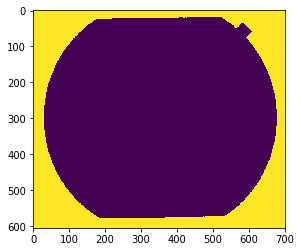

In [311]:
def create_stare_mask(image, image_path=None):
    from skimage.filters import threshold_li
    from skimage.color import rgb2gray
    im_gray = rgb2gray(image)
    thresh_val = threshold_li(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)

    # Make sure the larger portion of the mask is considered background
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
        imshow(mask)
    if image_path:    
        save_image(image_path, mask)
        
create_stare_mask(stare_image)